<a href="https://colab.research.google.com/github/bhuiyanmobasshir94/MultiCoNER/blob/main/tutorials/bangla_bert_neuralspace_reverie_indic_transformers_bn_bert_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install seqeval

     |████████████████████████████████| 3.3 MB 3.2 MB/s 
     |████████████████████████████████| 61 kB 519 kB/s 
     |████████████████████████████████| 3.3 MB 33.1 MB/s 
     |████████████████████████████████| 596 kB 30.9 MB/s 
     |████████████████████████████████| 895 kB 35.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 43 kB 1.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=dcd0f0c04fb8013f22a9baab2f60b15ba14918af4f017aef618a89d51626d4bc
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
data = pd.read_csv(r"/content/drive/MyDrive/DATASETS/SemEvalbn_train.csv", encoding="UTF-8").fillna(method="ffill")
data.head(10)

,Sentence #,Word,Tag
0,Sentence: 1,২০১৮,O
1,Sentence: 1,এর,O
2,Sentence: 1,সেরা,O
3,Sentence: 1,(বর্ণানুক্রমিকভাবে,O
4,Sentence: 1,"তালিকাভুক্ত,",O
5,Sentence: 1,র‍্যাঙ্ক,O
6,Sentence: 1,করা,O
7,Sentence: 1,"হয়নি),",O
8,Sentence: 1,এনপিআর,B-CORP
9,Sentence: 2,১৮২৫,O


In [4]:
words = list(set(data["Word"].values))
n_words = len(words); n_words

33185

In [5]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
       # agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
        #                                                   s["Tag"].values.tolist())]
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [6]:
getter = SentenceGetter(data)

In [7]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

#an example of sentence

['২০১৮',
 'এর',
 'সেরা',
 '(বর্ণানুক্রমিকভাবে',
 'তালিকাভুক্ত,',
 'র\u200d্যাঙ্ক',
 'করা',
 'হয়নি),',
 'এনপিআর']

In [8]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])
#BIO schema is followed in the datSET

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CORP']


In [9]:
from collections import Counter
from keras.preprocessing.sequence import pad_sequences

word_cnt = Counter(data["Word"].values)
vocabulary = set(w[0] for w in word_cnt.most_common(5000))

In [10]:
word2idx = {"PAD": 0, "UNK": 1}
word2idx.update({w: i for i, w in enumerate(words) if w in vocabulary})

In [11]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
#Padding is addded end of each sentence,

Preprocess the sentence nd labels. prepare to use with pytorch and bert

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.10.0+cu111'

In [13]:
MAX_LEN = 75
bs = 32
#batch size = bs
# sentence length fixed to 75 i.e. 75 tokens
# but bert supports up to 512 tokens 

Here we fix some configurations. We will limit our sequence length to 75 tokens and we will use a batch size of 32 as suggested by the Bert paper. Note, that Bert supports sequences of up to 512 tokens.

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [15]:
torch.cuda.get_device_name(0)


'Tesla K80'

In [16]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False) 
#cased better for for ner
# from simpletransformers.classification import ClassificationModel

# tokenizer = ClassificationModel('bert', 'sagorsarker/bangla-bert-base')
# tokenizer = BertTokenizer.from_pretrained('neuralspace-reverie/indic-transformers-bn-bert') 
tokenizer = BertTokenizer.from_pretrained('csebuetnlp/banglabert') 
# tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base') 
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased') 
#cased better for for ner

Downloading:   0%|          | 0.00/516k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/119 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/586 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'ElectraTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [17]:
# tokenize wala step ## wala step jaise gunships ##shipa
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [18]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]


In [19]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]


In [20]:
#cut and pad to the desied length 75 bcz ab no of token increase ho gya
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [21]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [22]:
#attenation mask to ignore PAD token
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]


In [23]:
#10per train and validATE
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [24]:
# convert to torch tenors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


In [25]:
#training time shuffling of the data and testing time we pass them sequentially
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


Fine tune

In [26]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


'4.13.0'

In [27]:
# model = ClassificationModel('bert', 'sagorsarker/bangla-bert-base', num_labels=5, use_cuda=True, args={
#     'reprocess_input_data': True,
#     'use_cached_eval_features': False,
#     'overwrite_output_dir': True,
#     'num_train_epochs': 3,
#     'silent': True
# })
model = BertForTokenClassification.from_pretrained(
    "csebuetnlp/banglabert",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at csebuetnlp/banglabert were not used when initializing BertForTokenClassification: ['electra.encoder.layer.0.intermediate.dense.bias', 'electra.encoder.layer.3.attention.self.value.weight', 'electra.encoder.layer.11.attention.output.LayerNorm.weight', 'electra.encoder.layer.2.attention.output.dense.weight', 'electra.encoder.layer.0.attention.self.value.bias', 'electra.encoder.layer.11.attention.output.LayerNorm.bias', 'electra.encoder.layer.6.attention.self.value.bias', 'electra.encoder.layer.8.output.dense.weight', 'electra.encoder.layer.9.attention.self.value.weight', 'electra.encoder.layer.4.attention.self.query.weight', 'electra.encoder.layer.8.attention.self.query.weight', 'electra.encoder.layer.7.attention.output.LayerNorm.bias', 'electra.encoder.layer.4.attention.output.dense.bias', 'electra.encoder.layer.3.attention.output.LayerNorm.bias', 'electra.encoder.layer.5.attention.self.query.bias', 'electra.encoder.layer.5.output.LayerNorm.weight

In [28]:
model.cuda();

now fine tuning uske liye optimizer use krna hai and we are using AdamW.

In [29]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [30]:
#schduler to reduce learning rate linearly throughout the epochs
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Fit bert for ner

In [31]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [32]:
from sklearn.metrics import f1_score
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    print()


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.8133423474991128


Epoch:  33%|███▎      | 1/3 [06:13<12:27, 373.52s/it]

Validation loss: 0.6646039883295695
Validation Accuracy: 0.1868108974358975

Average train loss: 0.5827318729353061


Epoch:  67%|██████▋   | 2/3 [12:26<06:13, 373.40s/it]

Validation loss: 0.5505656090875467
Validation Accuracy: 0.1917167467948718

Average train loss: 0.45758643732546656


Epoch: 100%|██████████| 3/3 [18:40<00:00, 373.66s/it]

Validation loss: 0.5204433655987183
Validation Accuracy: 0.19350627670940168



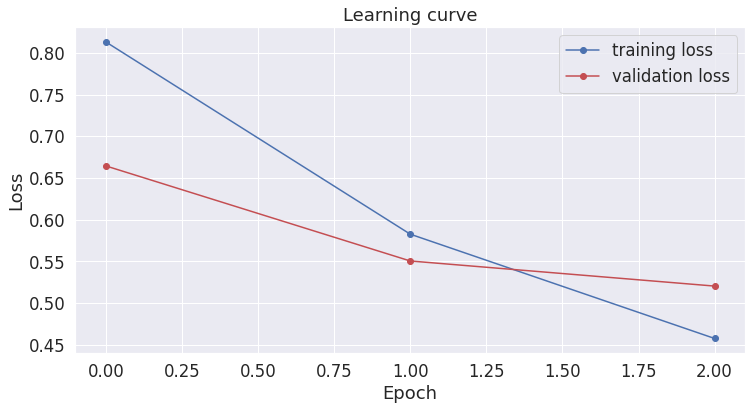

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [35]:
test_sentence = "শেখ হাসিনা বাংলদেশে এসেছেন কোরিয়ানদের সাথে দারাজে অরডার করতে"

In [36]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()


In [37]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


In [38]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [39]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	শেখ
O	হাসিনা
O	বাংলদেশে
O	এসেছেন
O	[UNK]
O	সাথে
B-PER	দারাজে
I-PER	অরডার
O	করতে
I-PER	[SEP]


In [40]:
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
#     print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))

In [41]:
from sklearn.metrics import f1_score
f1_score(pred_tags, valid_tags, average='micro')

0.8493826216598493

In [42]:
from sklearn.metrics import precision_score
precision_score(pred_tags, valid_tags, average='micro')

0.8493826216598493

In [43]:
from sklearn.metrics import recall_score
recall_score(pred_tags, valid_tags, average='micro')

0.8493826216598493

In [44]:
from sklearn.metrics import f1_score
f1_score(pred_tags, valid_tags, average='macro')

0.45332713305799704

In [45]:
from sklearn.metrics import f1_score
f1_score(pred_tags, valid_tags, average='weighted')

0.8624962621119209

In [46]:
from sklearn.metrics import classification_report
print(classification_report(valid_tags, pred_tags))

              precision    recall  f1-score   support

      B-CORP       0.56      0.36      0.44       571
        B-CW       0.50      0.16      0.24       383
       B-GRP       0.52      0.45      0.48       429
       B-LOC       0.47      0.50      0.48       522
       B-PER       0.48      0.51      0.50       432
      B-PROD       0.40      0.36      0.38       551
      I-CORP       0.62      0.43      0.50       457
        I-CW       0.35      0.13      0.19       444
       I-GRP       0.54      0.54      0.54       586
       I-LOC       0.54      0.25      0.34       244
       I-PER       0.49      0.69      0.57       650
      I-PROD       0.52      0.20      0.29       268
           O       0.92      0.97      0.95     20622

    accuracy                           0.85     26159
   macro avg       0.53      0.43      0.45     26159
weighted avg       0.83      0.85      0.84     26159



In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix(valid_tags, pred_tags)

array([[  204,     8,    30,    43,    21,    40,    20,     7,    13,
            2,    38,     2,   143],
       [   17,    61,    11,    15,    25,    27,     3,    22,     5,
            2,    17,     0,   178],
       [   14,     8,   193,    24,    23,     6,     2,     1,    47,
            1,    13,     0,    97],
       [   14,     0,    22,   260,    20,    29,     9,     1,    10,
           16,    17,     1,   123],
       [    4,     5,     3,    13,   221,    11,     0,     3,     3,
            0,    69,     0,   100],
       [   19,     4,     8,    21,    21,   198,     2,     2,     2,
            0,    27,     4,   243],
       [   32,     0,     4,    15,     3,     4,   195,     6,    55,
            3,    35,     3,   102],
       [    6,    17,     4,    12,     2,    11,    17,    57,    22,
            4,    56,     5,   231],
       [    6,     1,    39,    21,     6,     3,    21,    11,   314,
            6,    42,     0,   116],
       [    1,     0,     3,

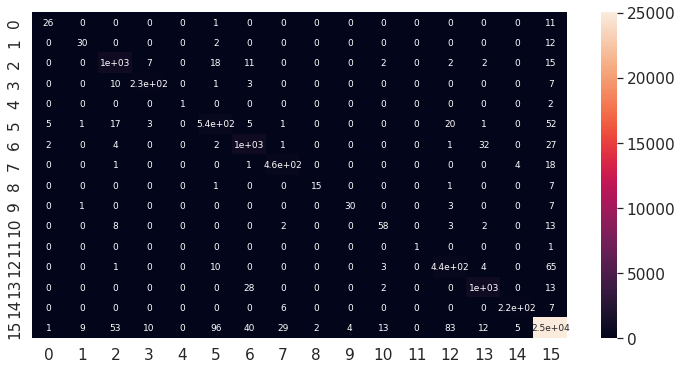

In [48]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[   26,     0,     0,     0,     0,     1,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    11],
       [    0,    30,     0,     0,     0,     2,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    12],
       [    0,     0,  1049,     7,     0,    18,    11,     0,     0,
            0,     2,     0,     2,     2,     0,    15],
       [    0,     0,    10,   228,     0,     1,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     7],
       [    0,     0,     0,     0,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     2],
       [    5,     1,    17,     3,     0,   537,     5,     1,     0,
            0,     0,     0,    20,     1,     0,    52],
       [    2,     0,     4,     0,     0,     2,  1027,     1,     0,
            0,     0,     0,     1,    32,     0,    27],
       [    0,     0,     1,     0,     0,     0,     1,   457,     0,
            0,     0,     0,     0,     0,     4,    18],
       [    0,     0,     0,     0,     0,     1,     0,     0,    15,
            0,     0,     0,     1,     0,     0,     7],
       [    0,     1,     0,     0,     0,     0,     0,     0,     0,
           30,     0,     0,     3,     0,     0,     7],
       [    0,     0,     8,     0,     0,     0,     0,     2,     0,
            0,    58,     0,     3,     2,     0,    13],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     1,     0,     0,     0,     1],
       [    0,     0,     1,     0,     0,    10,     0,     0,     0,
            0,     3,     0,   438,     4,     0,    65],
       [    0,     0,     0,     0,     0,     0,    28,     0,     0,
            0,     2,     0,     0,  1003,     0,    13],
       [    0,     0,     0,     0,     0,     0,     0,     6,     0,
            0,     0,     0,     0,     0,   219,     7],
       [    1,     9,    53,    10,     0,    96,    40,    29,     2,
            4,    13,     0,    83,    12,     5, 25028]]
df_cm = pd.DataFrame(array, range(16), range(16))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}) # font size

plt.show()

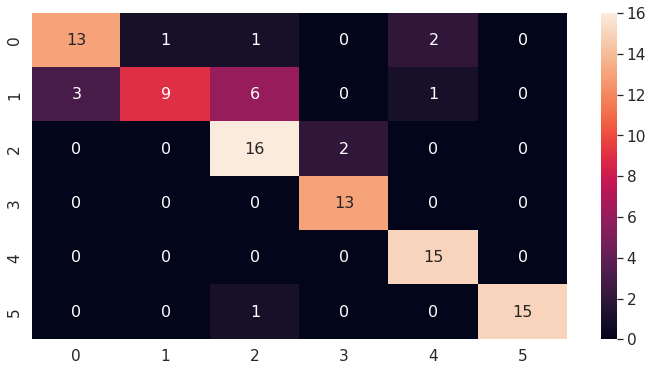

In [49]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[13,1,1,0,2,0],
         [3,9,6,0,1,0],
         [0,0,16,2,0,0],
         [0,0,0,13,0,0],
         [0,0,0,0,15,0],
         [0,0,1,0,0,15]]

df_cm = pd.DataFrame(array, range(6), range(6))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [50]:
# Custom Tokenizer
import re
import string

In [51]:
# test
sent="শেখ হাসিনা বাংলদেশে এসেছেন কোরিয়ানদের সাথে দারাজে অরডার করতে"
a=[tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent))]
input_ids=pad_sequences(a,maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
attention_masks=[[float(i>0) for i in ii] for ii in input_ids]
tr_inputs = torch.tensor(input_ids)
tr_masks = torch.tensor(attention_masks)
valid_data = TensorDataset(tr_inputs, tr_masks)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [52]:
predictions = []
for batch in valid_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch
    with torch.no_grad():
#         tmp_eval_loss = model(b_input_ids, token_type_ids=None,
#                               attention_mask=b_input_mask, labels=b_labels)
        logits = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)[0]
        
    logits = logits.detach().cpu().numpy()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
tags=[[p_i for p_i in p] for p in predictions]

In [53]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()


In [54]:
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(tokenize(sent), tags[0]):
    print("{:15}: {:5}".format(w, tag_values[pred]))

Word           ||Prediction
শেখ            : O    
হাসিনা         : O    
বাংলদেশে       : O    
এসেছেন         : O    
কোরিয়ানদের     : O    
সাথে           : O    
দারাজে         : O    
অরডার          : B-PER
করতে           : B-PER


In [55]:
!pip install cdifflib

  Created wheel for cdifflib: filename=cdifflib-1.2.5-cp37-cp37m-linux_x86_64.whl size=32972 sha256=1cac6bd22aade3f6efc09fc5d81597483d5ae58f1d4323c37f88fac5a5cba0ad
  Stored in directory: /root/.cache/pip/wheels/01/b2/78/56b07db93d847924bb3786d6b155675652cbe7f75103bb9c2f
Successfully built cdifflib


In [56]:
from cdifflib import CSequenceMatcher
def similar(a, b):
    return CSequenceMatcher(None, a,b).ratio()

In [57]:
similar("ডেলোপি","দেলোপি")

0.8333333333333334

In [58]:
PATH = "/content/drive/MyDrive/DATASETS/MediNER.pt"

# Save
torch.save(model, PATH)

# Load
model = torch.load(PATH)
model.eval()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/NER_DataSet/2knews2.csv", encoding="UTF-8")

In [ ]:
df['sent'] = df['sent'].astype(str)

In [ ]:
# test
# def indic(sent):
from tqdm import tqdm

ls_word_b = []
ls_tag_b = []
for sent in tqdm(df["sent"]):
  a=[tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent))]
  input_ids=pad_sequences(a,maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  attention_masks=[[float(i>0) for i in ii] for ii in input_ids]
  tr_inputs = torch.tensor(input_ids)
  tr_masks = torch.tensor(attention_masks)
  valid_data = TensorDataset(tr_inputs, tr_masks)
  valid_sampler = SequentialSampler(valid_data)
  valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)
  predictions = []
  for batch in valid_dataloader:
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask = batch
      with torch.no_grad():
  #         tmp_eval_loss = model(b_input_ids, token_type_ids=None,
  #                               attention_mask=b_input_mask, labels=b_labels)
          logits = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)[0]
          
      logits = logits.detach().cpu().numpy()
      predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
  tags=[[p_i for p_i in p] for p in predictions]
  re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
  def tokenize(s): return re_tok.sub(r' \1 ', s).split()
  ls_word = []
  ls_tag = []
  for w, pred in zip(tokenize(sent), tags[0]):
    # print(w)
    # print(tag_values[pred])
    ls_word.append(w)
    ls_tag.append(tag_values[pred])
  ls_word_b.append(ls_word)
  ls_tag_b.append(ls_tag)

In [ ]:
header = []
Word = []

for idx, word in enumerate(ls_word_b):
    for idy,token in enumerate(word):
        Word.append(token)
        if idy == 0:
            header.append('Sentence: ' + str(idx+1))
        else:
            header.append('NaN')

train_dataFrame = pd.DataFrame(list(zip(header, Word)), columns=['Sentence #','Word'])

In [ ]:
header = []
Word = []

for idx, word in enumerate(ls_tag_b):
    for idy,token in enumerate(word):
        Word.append(token)
        if idy == 0:
            header.append('Sentence: ' + str(idx+1))
        else:
            header.append('NaN')

train_dataFrame23 = pd.DataFrame(list(zip(header, Word)), columns=['Sentence #','Word'])

In [ ]:
gs = []
for i in train_dataFrame23["Word"]:
  gs.append(i)

In [ ]:
train_dataFrame["Tag"] = gs
train_dataFrame

In [ ]:
train_dataFrame.to_csv("/content/drive/MyDrive/NER_DataSet/test_newspublicNer.csv", index=False)

In [ ]:
train_dataFrame.tail(30)